# Spark eda

In this demo, we will use spark to do EDA (Exploratory Data Analysis) on all 911 calls of san francisco of the last 10 year

In [2]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, to_timestamp, round,unix_timestamp, sum, avg, min, max, year, weekofyear

from pyspark.sql.types import IntegerType
import numpy as np # linear algebra
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import pgeocode

In [ ]:
! pip install pgeocode chart_studio

In [3]:
local=False
if local:
    spark=SparkSession.builder.master("local[4]") \
                  .appName("spark_eda").getOrCreate()
else:
    spark=SparkSession.builder \
                      .master("k8s://https://kubernetes.default.svc:443") \
                      .appName("spark_eda") \
                      .config("spark.kubernetes.container.image",os.environ["IMAGE_NAME"]) \
                      .config("spark.kubernetes.authenticate.driver.serviceAccountName",os.environ['KUBERNETES_SERVICE_ACCOUNT']) \
                      .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE']) \
                      .config("spark.executor.instances", "4") \
                      .config("spark.executor.memory","2g") \
                      .config("spark.driver.memory","2g") \
                      .enableHiveSupport() \
                      .getOrCreate()

2022-10-27 06:59:36,607 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-10-27 06:59:36,818 INFO spark.SparkContext: Running Spark version 3.3.0
2022-10-27 06:59:36,865 INFO resource.ResourceUtils: ==============================================================
2022-10-27 06:59:36,866 INFO resource.ResourceUtils: No custom resources configured for spark.driver.
2022-10-27 06:59:36,866 INFO resource.ResourceUtils: ==============================================================
2022-10-27 06:59:36,867 INFO spark.SparkContext: Submitted application: spark_data_eda
2022-10-27 06:59:36,887 INFO resource.ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 2048, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
2022-10-27 06:

In [4]:
def set_log_level(spark_session,log_level:str):
    logger = spark_session.sparkContext._jvm.org.apache.log4j
    if log_level=="INFO":
        logger_level = logger.Level.INFO
    elif log_level=="WARN":
        logger_level = logger.Level.WARN
    elif log_level=="ERROR":
        logger_level = logger.Level.ERROR
    else:
        raise ValueError("The log_level must be INFO, WARN or ERROR")
    logger.LogManager.getLogger("org").setLevel(logger_level)
    logger.LogManager.getLogger("akka").setLevel(logger_level)
    
set_log_level(spark,"ERROR")

## Check worker number

### Check the worker number via Spark UI

To check how many workers with gpu has been deoployed. You can use the spark UI to view the status of all the workers.

### Check the worker number via kubectl
You can also use below command to check your spark worker number

In [5]:
! kubectl get pods -l spark-role=executor

NAME                                     READY   STATUS    RESTARTS   AGE
spark-data-eda-a4347c84183d3e5b-exec-1   1/1     Running   0          29s
spark-data-eda-a4347c84183d3e5b-exec-2   1/1     Running   0          29s
spark-data-eda-a4347c84183d3e5b-exec-3   1/1     Running   0          29s
spark-data-eda-a4347c84183d3e5b-exec-4   1/1     Running   0          29s


## Do some analysis

In [6]:
work_dir="s3a://pengfei"
parquet_file_name="onyxia_demo/sf_fire"
data_path=f"{work_dir}/{parquet_file_name}"

In [7]:
df_raw=spark.read.parquet(data_path)

In [8]:
row_nb=df_raw.count()
col_nb=len(df_raw.columns)

print(f"data frame has : {row_nb} rows and {col_nb} columns")

data frame has : 5500519 rows and 34 columns


In [9]:
df_raw.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- ReceivedDtTm: string (nullable = true)
 |-- EntryDtTm: string (nullable = true)
 |-- DispatchDtTm: string (nullable = true)
 |-- ResponseDtTm: string (nullable = true)
 |-- OnSceneDtTm: string (nullable = true)
 |-- TransportDtTm: string (nullable = true)
 |-- HospitalDtTm: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- ZipcodeofIncident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPr

In [10]:
df_raw.show(5)

+----------+------+--------------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------------+--------------------+--------------------+--------------------+-------------+-----------------+---------+-----------+----+----------------+--------+-------------+-------+-------------+--------------+--------+--------------------------+----------------------+------------------+--------------------+-------------+--------------------+
|CallNumber|UnitID|IncidentNumber|            CallType|  CallDate| WatchDate|        ReceivedDtTm|           EntryDtTm|        DispatchDtTm|        ResponseDtTm|         OnSceneDtTm|TransportDtTm|HospitalDtTm|CallFinalDisposition|       AvailableDtTm|             Address|         City|ZipcodeofIncident|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumberofAlarms|UnitType|Unitsequenceincalldispatch|FirePreventio

## Q1 How many distinct types of calls were made to the Fire Department?



In [11]:
all_call_type=df_raw.select("CallType").filter(col("CallType").isNotNull()).distinct()

all_call_type.show(truncate=False)

+--------------------------------------------+
|CallType                                    |
+--------------------------------------------+
|Elevator / Escalator Rescue                 |
|Marine Fire                                 |
|Aircraft Emergency                          |
|Confined Space / Structure Collapse         |
|Administrative                              |
|Alarms                                      |
|Odor (Strange / Unknown)                    |
|Citizen Assist / Service Call               |
|HazMat                                      |
|Watercraft in Distress                      |
|Explosion                                   |
|Oil Spill                                   |
|Vehicle Fire                                |
|Suspicious Package                          |
|Train / Rail Fire                           |
|Extrication / Entrapped (Machinery, Vehicle)|
|Other                                       |
|Outside Fire                                |
|Traffic Coll

In [12]:
total_num=all_call_type.count()

print(f"The total number of distinct call types are: {total_num}")

The total number of distinct call types are: 32


## Q2 What is the top 10 call type of San Francisco 911 service?

In [13]:
top10CallType=df_raw.groupBy("CallType").agg(count("IncidentNumber").alias("incident_number")).orderBy(col("incident_number").desc()).limit(10)
top10CallType.show(20,truncate=False)

+-------------------------------+---------------+
|CallType                       |incident_number|
+-------------------------------+---------------+
|Medical Incident               |3596332        |
|Structure Fire                 |681179         |
|Alarms                         |599263         |
|Traffic Collision              |224909         |
|Other                          |87468          |
|Citizen Assist / Service Call  |82173          |
|Outside Fire                   |68491          |
|Water Rescue                   |28253          |
|Vehicle Fire                   |25512          |
|Gas Leak (Natural and LP Gases)|22961          |
+-------------------------------+---------------+



In [14]:
callPdf=top10CallType.toPandas()

call=callPdf['CallType'].tolist()
incident_count=callPdf['incident_number'].tolist()

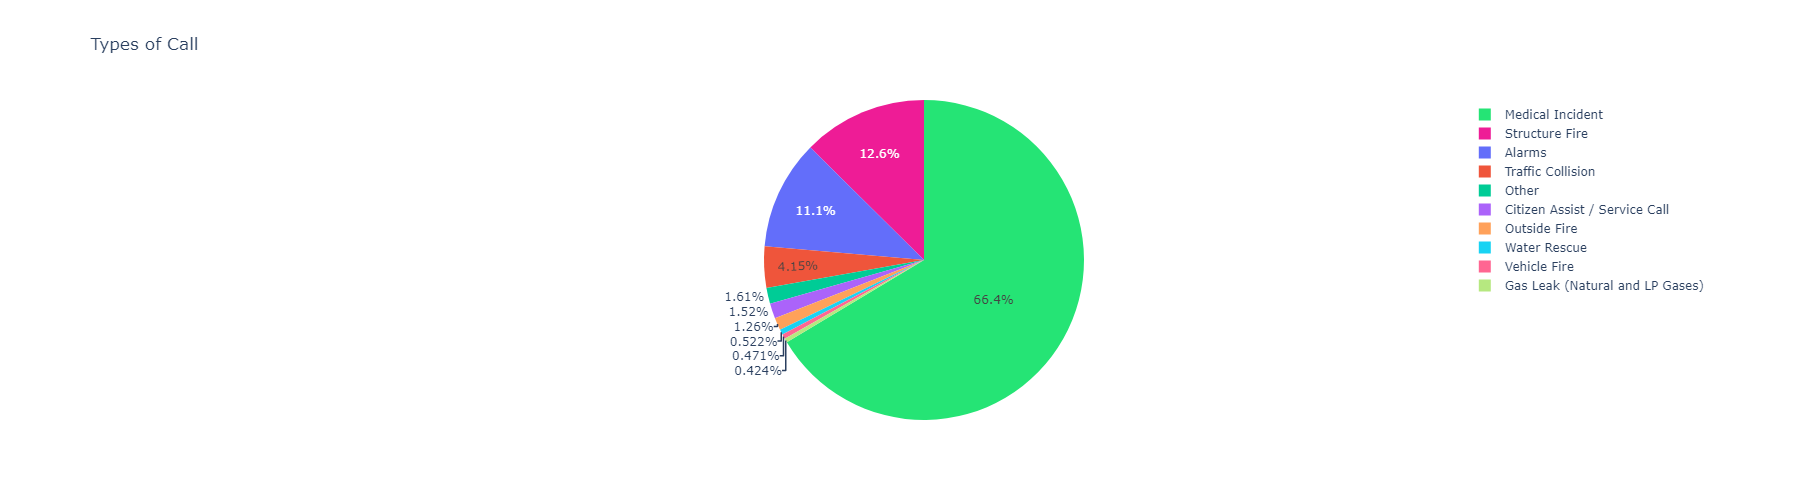

In [15]:
pie_visual = go.Pie(labels=call, values=incident_count, marker=dict(colors=['#25e475', '#ee1c96',]))

layout = go.Layout(title='Types of Call', width=800, height=500)
fig = go.Figure(data=[pie_visual], layout=layout)
iplot(fig)

## Q3 Find out all response or delayed times greater than 5 mins?

1. Rename the column Delay - > ReponseDelayedinMins
2. Returns a new DataFrame
3. Find out all calls where the response time to the fire site was delayed for more than 5 mins

We don't have a column `Delay`, so we need to use 
- ReceivedDtTm
- EntryDtTm
- DispatchDtTm
- ResponseDtTm
- OnSceneDtTm

In [16]:
df_raw.select("IncidentNumber","ReceivedDtTm","EntryDtTm","DispatchDtTm","ResponseDtTm","OnSceneDtTm").show(2,truncate=False)

+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|IncidentNumber|ReceivedDtTm          |EntryDtTm             |DispatchDtTm          |ResponseDtTm          |OnSceneDtTm           |
+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|21017645      |02/08/2021 01:00:14 PM|02/08/2021 01:01:36 PM|02/08/2021 01:01:40 PM|02/08/2021 01:03:21 PM|02/08/2021 01:05:44 PM|
|21017596      |02/08/2021 10:54:56 AM|02/08/2021 10:56:50 AM|02/08/2021 10:56:57 AM|02/08/2021 10:57:07 AM|02/08/2021 10:59:34 AM|
+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+
only showing top 2 rows



We could use `OnSeneDtTm-ReceivedDtTm` to evaluate the deplay between a call received by the fire departement and fire fighter on scene. The problem here is they are all in String, we need to convert them into timestamp first.

In [17]:
incident_receive_time_col="ReceivedTime"
incident_on_sene_time_col="OnSeneTime"

In [18]:
date_format="MM/dd/yyyy"
time_format="MM/dd/yyyy hh:mm:ss a"
fire_df1=df_raw.withColumn(incident_receive_time_col,to_timestamp(col("ReceivedDtTm"),time_format)) \
.drop("ReceivedDtTm") \
.withColumn(incident_on_sene_time_col,to_timestamp(col("OnSceneDtTm"),time_format)) \
.drop("OnSceneDtTm") \
.withColumn("CallDateTs",to_timestamp(col("CallDate"),date_format)) \
.drop("CallDate")

In [19]:
fire_df1.select(incident_receive_time_col,incident_on_sene_time_col).show()

+-------------------+-------------------+
|       ReceivedTime|         OnSeneTime|
+-------------------+-------------------+
|2021-02-08 13:00:14|2021-02-08 13:05:44|
|2021-02-08 10:54:56|2021-02-08 10:59:34|
|2021-02-08 10:18:53|2021-02-08 10:27:42|
|2021-02-08 08:50:27|               null|
|2021-02-07 21:18:38|2021-02-07 21:25:11|
|2021-02-07 17:24:48|2021-02-07 17:30:04|
|2021-02-07 15:09:02|2021-02-07 15:11:32|
|2021-02-07 13:07:40|2021-02-07 13:11:29|
|2021-02-07 12:00:39|2021-02-07 12:12:28|
|2021-02-07 05:41:18|2021-02-07 05:46:20|
|2021-02-07 02:11:22|2021-02-07 02:17:16|
|2021-02-06 18:50:12|2021-02-06 18:56:34|
|2021-02-06 06:44:40|2021-02-06 06:57:06|
|2021-02-06 05:33:10|2021-02-06 05:40:11|
|2021-02-06 03:24:29|2021-02-06 03:36:59|
|2021-02-05 17:04:25|               null|
|2021-02-05 08:01:17|2021-02-05 08:13:31|
|2021-02-05 05:22:23|               null|
|2021-02-05 19:29:12|               null|
|2021-02-08 08:09:24|2021-02-08 08:49:44|
+-------------------+-------------

Now we have new problems?
1. You can notice that we have many null values in OnSeneTime, what should we do?
2. How to calculate timestamp difference in minutes?

In [20]:
delay_df=fire_df1.withColumn("Delay",round((unix_timestamp(incident_on_sene_time_col) - unix_timestamp(incident_receive_time_col))/60))

In [21]:
delay_df.select("IncidentNumber","Delay").show()

+--------------+-----+
|IncidentNumber|Delay|
+--------------+-----+
|      21017645|  6.0|
|      21017596|  5.0|
|      21017578|  9.0|
|      21017552| null|
|      21017398|  7.0|
|      21017307|  5.0|
|      21017263|  3.0|
|      21017206|  4.0|
|      21017173| 12.0|
|      21017065|  5.0|
|      21017021|  6.0|
|      21016911|  6.0|
|      21016646| 12.0|
|      21016635|  7.0|
|      21016610| 13.0|
|      21016433| null|
|      21016151| 12.0|
|      21016122| null|
|      21016489| null|
|      21017540| 40.0|
+--------------+-----+
only showing top 20 rows



In [22]:
delayed_response=delay_df.filter(col("Delay")>5)
delayed_response.show(2)

+----------+------+--------------+--------------------+----------+--------------------+--------------------+--------------------+-------------+------------+--------------------+--------------------+--------------------+-------------+-----------------+---------+-----------+----+----------------+--------+-------------+-------+-------------+--------------+--------+--------------------------+----------------------+------------------+--------------------+-------------+--------------------+-------------------+-------------------+-------------------+-----+
|CallNumber|UnitID|IncidentNumber|            CallType| WatchDate|           EntryDtTm|        DispatchDtTm|        ResponseDtTm|TransportDtTm|HospitalDtTm|CallFinalDisposition|       AvailableDtTm|             Address|         City|ZipcodeofIncident|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumberofAlarms|UnitType|Unitsequenceincalldispatch|FirePreventionDistrict|SupervisorDistrict|Neighborhoo

## Q4. Who(zip codes) calls the most?

Let's investigate what zip codes in San Francisco calls the most and what type where they.

- Group them by Zip code
- Count them and display them in descending order
- View them on a map

In [40]:
topCallZone=df_raw.groupBy("ZipcodeofIncident").agg(count("IncidentNumber").alias("incident_number")).orderBy(col("incident_number").desc()).limit(20)

In [41]:
topCallZone.show(20)

+-----------------+---------------+
|ZipcodeofIncident|incident_number|
+-----------------+---------------+
|            94102|         697419|
|            94103|         668617|
|            94109|         462364|
|            94110|         461606|
|            94124|         286960|
|            94112|         257640|
|            94115|         242599|
|            94107|         218105|
|            94122|         194590|
|            94133|         192968|
|            94117|         183151|
|            94114|         163557|
|            94118|         161704|
|            94134|         151536|
|            94121|         145369|
|            94132|         132563|
|            94105|         131931|
|            94108|         126418|
|            94116|         117388|
|            94123|         115148|
+-----------------+---------------+



In [25]:
us_map=pgeocode.Nominatim("US")
address=us_map.query_postal_code("94133")
print(type(address))
print(address)

<class 'pandas.core.series.Series'>
postal_code                                  94133
country_code                                    US
place_name                           San Francisco
state_name                              California
state_code                                      CA
county_name       City and County of San Francisco
county_code                                   75.0
community_name                                None
community_code                                 NaN
latitude                                   37.8002
longitude                                -122.4091
accuracy                                       4.0
Name: 0, dtype: object


In [26]:
print(f"latitude: {address['latitude']}, longitude : {address['longitude']}")

latitude: 37.8002, longitude : -122.4091


In [ ]:
# todo dataviz of incident_number on a map with zipcode

## Q5. What San Francisco neighborhoods are in the zip codes 94102 and 94103

Let's find out the neighborhoods associated with these two zip codes. In all likelihood, these are some of the contested neighborhood with high reported crimes.

In [27]:
zipcode_col="ZipcodeofIncident"
df_raw.select("NeighborhoodDistrict",zipcode_col).filter((col(zipcode_col)==94102)|(col(zipcode_col)==94103)).distinct().show(truncate=False)

+------------------------------+-----------------+
|NeighborhoodDistrict          |ZipcodeofIncident|
+------------------------------+-----------------+
|Potrero Hill                  |94103            |
|Western Addition              |94102            |
|Tenderloin                    |94102            |
|Nob Hill                      |94102            |
|Castro/Upper Market           |94103            |
|South of Market               |94102            |
|South of Market               |94103            |
|Hayes Valley                  |94103            |
|Financial District/South Beach|94102            |
|Mission Bay                   |94103            |
|Tenderloin                    |94103            |
|Financial District/South Beach|94103            |
|Hayes Valley                  |94102            |
|Mission                       |94103            |
|Mission                       |94102            |
+------------------------------+-----------------+



## Q6. What was the sum of all calls, average, min and max of the response times for calls?

Let's use the built-in Spark SQL functions to compute the sum, avg, min, and max of few columns:

- Number of Total Alarms
- What were the min and max the delay in response time before the Fire Dept arrived at the scene of the call

In [28]:
delay_df.select("NumberofAlarms","Delay").show()

+--------------+-----+
|NumberofAlarms|Delay|
+--------------+-----+
|             1|  6.0|
|             1|  5.0|
|             1|  9.0|
|             1| null|
|             1|  7.0|
|             1|  5.0|
|             1|  3.0|
|             1|  4.0|
|             1| 12.0|
|             1|  5.0|
|             1|  6.0|
|             1|  6.0|
|             1| 12.0|
|             1|  7.0|
|             1| 13.0|
|             1| null|
|             1| 12.0|
|             1| null|
|             1| null|
|             1| 40.0|
+--------------+-----+
only showing top 20 rows



In [29]:
delay_df.select(sum("NumberofAlarms"), avg("Delay"),min("Delay"),max("Delay")).show()

+-------------------+----------------+----------+----------+
|sum(NumberofAlarms)|      avg(Delay)|min(Delay)|max(Delay)|
+-------------------+----------------+----------+----------+
|            5529669|8.75188972043176| -132759.0|    2562.0|
+-------------------+----------------+----------+----------+



## Q7. How many distinct years of data is in the dataset?

In question 3, we already convert the `CallDate (string)` column to `CallDateTs(timestamp)`.
Now we can use the `year()` function to get the year of all `CallDateTs`.


In [31]:
delay_df.select("CallDateTs").show(1)

+-------------------+
|         CallDateTs|
+-------------------+
|2021-02-08 00:00:00|
+-------------------+
only showing top 1 row



In [32]:
delay_df.select(year("CallDateTs")).distinct().orderBy(year("CallDateTs")).show(30)

+----------------+
|year(CallDateTs)|
+----------------+
|            2000|
|            2001|
|            2002|
|            2003|
|            2004|
|            2005|
|            2006|
|            2007|
|            2008|
|            2009|
|            2010|
|            2011|
|            2012|
|            2013|
|            2014|
|            2015|
|            2016|
|            2017|
|            2018|
|            2019|
|            2020|
|            2021|
+----------------+



## Q8. Which week of the year 2018 had the most calls?

Note: Week 1 is the New Years' week and week 25 is the week of the July 4. Loads of fireworks, so it makes sense the higher number of calls.

In [34]:
top20Week=delay_df.filter(year("CallDateTs")==2018).groupBy(weekofyear("CallDateTs")).agg(count("IncidentNumber").alias("incident_number")).orderBy(col("incident_number").desc()).limit(20)

In [35]:
top20Week.show(10)

+----------------------+---------------+
|weekofyear(CallDateTs)|incident_number|
+----------------------+---------------+
|                     1|           7545|
|                    25|           6425|
|                    49|           6354|
|                    22|           6328|
|                    13|           6321|
|                    27|           6289|
|                    40|           6252|
|                    44|           6250|
|                    16|           6217|
|                    46|           6209|
+----------------------+---------------+
only showing top 10 rows



## Q9 What neighborhoods in San Francisco had the worst response time in 2018?

It appears that the average response time for `Lincoln Park` is more than 13, while `Haight Ashbury` only took 8 mins.

In [36]:
delay_time_by_neighborhood_desc=delay_df.filter(year("CallDateTs")==2018).groupBy("NeighborhoodDistrict").agg(avg("Delay").alias("avg_delay")).orderBy(col("avg_delay").desc())

In [37]:
delay_time_by_neighborhood_desc.show(20,False)

+------------------------------+------------------+
|NeighborhoodDistrict          |avg_delay         |
+------------------------------+------------------+
|Lincoln Park                  |13.192708333333334|
|Treasure Island               |13.04574332909784 |
|Presidio                      |12.169702780441035|
|Visitacion Valley             |11.416916416916417|
|Lakeshore                     |11.385576672741474|
|Twin Peaks                    |10.587329780935464|
|Bayview Hunters Point         |10.434967012252592|
|Golden Gate Park              |10.28022759601707 |
|Sunset/Parkside               |10.263134609003428|
|Portola                       |10.253227821740941|
|Bernal Heights                |10.179090029041626|
|Financial District/South Beach|10.11780910711392 |
|Excelsior                     |9.974632843791722 |
|Glen Park                     |9.93956043956044  |
|West of Twin Peaks            |9.901357978121464 |
|Chinatown                     |9.862294432336041 |
|None       

In [38]:
delay_time_by_neighborhood_asc=delay_df.filter(year("CallDateTs")==2018).groupBy("NeighborhoodDistrict").agg(avg("Delay").alias("avg_delay")).orderBy(col("avg_delay").asc())

In [39]:
delay_time_by_neighborhood_asc.show(20,False)

+--------------------+-----------------+
|NeighborhoodDistrict|avg_delay        |
+--------------------+-----------------+
|Haight Ashbury      |8.196945337620578|
|Nob Hill            |8.27028404024965 |
|Pacific Heights     |8.308811959087333|
|Castro/Upper Market |8.641526578827806|
|Hayes Valley        |8.650371087447564|
|Mission             |8.660104928030133|
|Inner Richmond      |8.877721443483448|
|Noe Valley          |8.912113106610622|
|Western Addition    |9.05             |
|Tenderloin          |9.05721863273425 |
|Lone Mountain/USF   |9.146173969914978|
|Russian Hill        |9.342880978865406|
|Presidio Heights    |9.361811391223156|
|Japantown           |9.392931392931393|
|Outer Mission       |9.54729160819534 |
|Seacliff            |9.55045871559633 |
|Potrero Hill        |9.58690397714788 |
|South of Market     |9.62836233407295 |
|Inner Sunset        |9.633784142137364|
|McLaren Park        |9.669039145907472|
+--------------------+-----------------+
only showing top